### Mostly for Newton Solve of Nonlinear Equations

$$
f^\phi (u) = 0
$$

### Summary: We NEED some sort of regularization or a tiny network

tensor([-0.0105], grad_fn=<AddBackward0>)


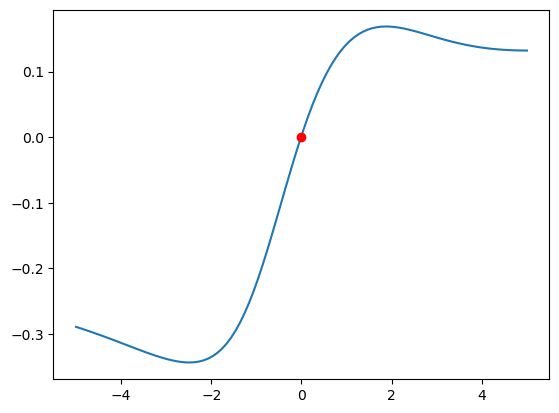

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
import sys
sys.path.append('../../../research/learning_numerics')
# from time_integrators import newton_solve
import solve_pdes

def newton_solve(f: Callable[[torch.Tensor], torch.Tensor], x0: torch.Tensor, max_iter: int = 10,
                 res_tol: float = 1e-6, x_tol: float = 1e-6, jac_stb_term = 0.0,
                 damp=1.0, verbose: bool = False):
    """Solves a nonlinear system through Newton's method, with functorch autodiff.

    Args:
        f: function to find zero of, (n,) -> (n,)
        x0: initial guess, (n,)
        max_iter: maximum number of iterations (default: 10)
        res_tol: tolerance for residual (default: 1e-6)
        x_tol: tolerance for change in x (default: 1e-6)

    Returns:
        x: solution to f(x) = 0, (n,1)
    """
    x = x0
    f_grad = lambda x: torch.func.jacrev(f)(x)
    exit_reason = 'max_iter'
    for i in range(max_iter):
        f_val = f(x)
        res = torch.linalg.norm(f_val)
        if res < res_tol:
            exit_reason = 'res_tol'
            break
        jac_f = f_grad(x)
        jac_f = jac_f + jac_stb_term * torch.eye(jac_f.shape[0])
        delta_x = -torch.linalg.solve(jac_f, f_val)
        x = x + damp * delta_x
        if torch.linalg.norm(delta_x) < x_tol:
            exit_reason = 'x_tol'
            break

    if verbose:
        print(f'Exited after: {i+1} / {max_iter} iterations, reason: {exit_reason}')

    return x

class SimpleFNN(nn.Module):
    def __init__(self, layers, activation):
        super(SimpleFNN, self).__init__()
        self.layers = layers
        self.activation = activation
        self.fc_layers = nn.ModuleList()

        # Create fully connected layers
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.fc_layers.append(activation)

    def forward(self, x):
        for layer in self.fc_layers:
            x = layer(x)
        return x

# Quick Review of Newton's Method
torch.manual_seed(0)
layers = [1, 32, 32, 1]
model = SimpleFNN(layers, nn.Tanh())

x = torch.linspace(-5, 5, 100).reshape(-1, 1)
x0 = torch.tensor([1.0])

xf = newton_solve(model, x0)
print(xf)

plt.plot(x, model(x).detach(), label='FNN')
plt.plot(xf.detach(), model(xf).detach(), 'ro', label='Fixed point')


### Now with 
$$
f^\phi (u) = \mathcal{N}^\phi (x, u, \Delta u, \Delta^2 u)
$$

Use true $f (u) = u_{xx} - 1 = 0$ as a test case, with $u(0) = 0, u(1) = 0$.

Exited after: 10 / 10 iterations, reason: max_iter
Epoch 0, Loss 0.018485043197870255
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 50, Loss 0.015757132321596146
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 100, Loss 0.013445155695080757
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 150, Loss 0.011457177810370922
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 200, Loss 0.009732063859701157
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 250, Loss 0.008227323181927204
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 300, Loss 0.006912402808666229
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 350, Loss 0.005764512345194817
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 400, Loss 0.004766029305756092
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 450, Loss 0.003902625059708953
Exited after: 10 / 10 iterations, reason: max_iter
Epoch 500, Loss 0.003162073902785778
Exited after: 10 / 10 iterations, r

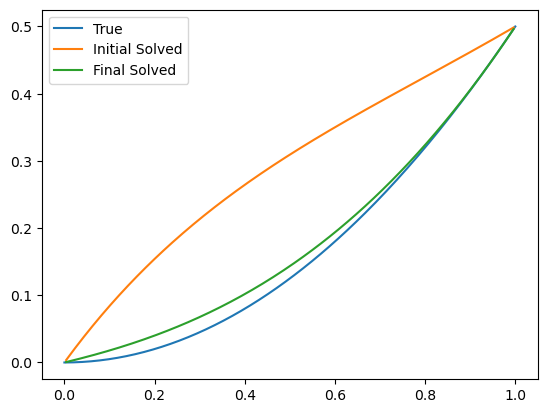

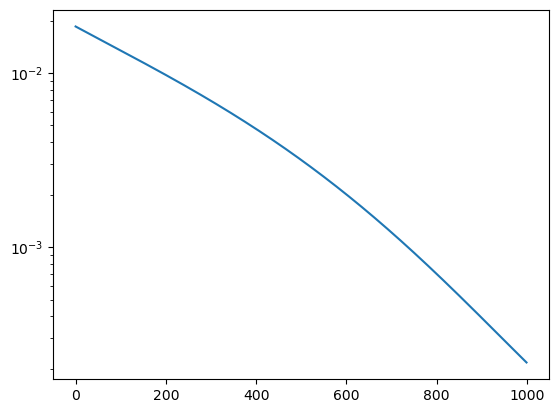

In [2]:
def N_true(big_u):
    # x, u, ux, uxx are columns
    x = big_u[:, 0]
    u = big_u[:, 1]
    ux = big_u[:, 2]
    uxx = big_u[:, 3]
    return (uxx - 1.0).unsqueeze(1)

n_x = 256
x = torch.linspace(0, 1, n_x)
u_true = 0.5 * x**2
ux_true = x
uxx_true = torch.ones_like(x)
big_u = torch.stack([x, u_true, ux_true, uxx_true], dim=1)

# create sine activation function
class SineActivation(nn.Module):
    def __init__(self):
        super(SineActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x)


class Sparse_N_Model(nn.Module):
    def __init__(self):
        super(Sparse_N_Model, self).__init__()
        self.bias = nn.Parameter(torch.zeros(1))
        self.u_term = nn.Linear(1, 1)
        self.ux_term = nn.Linear(1, 1)
        self.uxx_term = nn.Linear(1, 1)

    def forward(self, big_u):
        u = big_u[:, 1].unsqueeze(1)
        ux = big_u[:, 2].unsqueeze(1)
        uxx = big_u[:, 3].unsqueeze(1)
        return self.u_term(u) + self.ux_term(ux) + self.uxx_term(uxx) + self.bias

N_layers = [4, 4, 1]
N_model = SimpleFNN(N_layers, SineActivation())
# N_model = Sparse_N_Model()

def f(u_int, N=N_model):
    u = torch.zeros(n_x)
    u[1:-1] = u_int
    u[-1] = u_true[-1]
    ux = solve_pdes.fd_centered(u, x)
    uxx = solve_pdes.fd_centered_2nd(u, x)
    big_u = torch.stack([x[1:-1], u[1:-1], ux, uxx], dim=1)
    # return N_true2(big_u)[:,0]
    return N(big_u)[:,0]

u_solve_int = x[1:-1] * u_true[-1]
damp = 1e0
u_solve_int = newton_solve(f, u_solve_int, damp=damp, max_iter=50).detach()

plt.plot(x, u_true, label='True')
plt.plot(x[1:-1], u_solve_int, label='Initial Solved')

epochs = 1000
lr = 1e-3
losses = np.zeros(epochs)
optimizer = torch.optim.SGD(N_model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(N_model.parameters(), lr=lr)

for epoch in range(epochs):
    print_update = epochs < 20 or epoch % (epochs // 20) == 0 or epoch == epochs - 1
    optimizer.zero_grad()
    u_solve_int = newton_solve(f, u_solve_int, damp=damp, verbose=print_update, max_iter=10, x_tol=1e-8, res_tol=1e-8)
    loss = torch.mean((u_solve_int - u_true[1:-1])**2)
    loss.backward()
    optimizer.step()
    losses[epoch] = loss.item()
    u_solve_int = u_solve_int.detach()
    if print_update:
        print(f'Epoch {epoch}, Loss {loss.item()}')
        # reset optimizer momentum and other
        # optimizer = torch.optim.Adam(N_model.parameters(), lr=lr)


plt.plot(x[1:-1], u_solve_int.detach(), label='Final Solved')
plt.legend()

plt.figure()
plt.semilogy(losses)